# back propogation, activation function and multi-layer perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Layer():
    def __init__(self):
        pass
    
    #forward 
    #compute output value y given input x
    def forward(self, x):
        raise NotImplementedError
    
    #backward pass
    #compute gradient for weight variables dE/dW
    #and compute gradient for input dE/dx
    #given 'node_grad' which is the gradient passed from the previous layers dE/dy
    def backward(self, node_grad):
        raise NotImplementedError
        
    #update weight variables based on gradient
    def update(self, learn_rate):
        raise NotImplementedError

Sigmoid Function

$$y = \frac{1}{1+e^{-x}}$$

Gradients 

$$\frac{\partial{y}}{\partial{x}}=y*(1-y)$$

Backpropogation

$$\frac{\partial{E}}{\partial{x}}=\frac{\partial{E}}{\partial{y}}*y*(1-y)$$

In [4]:
class Sigmoid(Layer):
    def forward(self, x):
        self.y = 1 / (1 + np.exp(-x))
        return self.y
    
    def backward(self, node_grad):
        return node_grad * self.y * (1 - self.y)
    
    def update(self, learn_rate):
        pass

Relu Function

$$
y= 
\begin{cases}
    x, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

Gradients 

$$
\frac{\partial{y}}{\partial{x}}= 
\begin{cases}
    1, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

Backpropogation

$$
\frac{\partial{E}}{\partial{x}}= 
\begin{cases}
    \frac{\partial{E}}{\partial{y}}, & \text{if } x\gt 0\\
    0, & \text{otherwise}
\end{cases}
$$

In [8]:
class Relu(Layer):
    def forward(self, x):
        self.x = x
        return np.maximum(0, self.x)
    
    def backward(self, node_grad):
        return node_grad * (self.x > 0)
    
    def update(self, learn_rate):
        pass

Softmax + CrossEntropy

For forward and backward computation, please check https://deepnotes.io/softmax-crossentropy

In [11]:
class Softmax_Cross_Entropy(Layer):
    def forward(self, x):
        exps = np.exp(x - np.max(x))
        self.y = exps / np.sum(exps)
        return self.y
    
    def backward(self, label):
        self.out_grad = self.y - label
        return self.out_grad
    
    def update(self, learning_rate):
        pass

Linear Layer

For forward and backward computation, please check http://cs231n.stanford.edu/handouts/linear-backprop.pdf

In [24]:
class Linear(Layer):
    def __init__(self, size_in, size_out, with_bias):
        self.size_in = size_in
        self.size_out = size_out
        self.with_bias = with_bias
        self.W = self.initialize_weight()
        if with_bias:
            self.b = np.zeros(size_out)
        
    def initialize_weight(self):
        epsilon = np.sqrt(2.0 / (self.size_in + self.size_out))
        return epsilon * (np.random.rand(self.size_in, self.size_out) * 2 - 1)
    
    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.W) + self.b
        return self.y
    
    def backward(self, node_grad):
        self.G_W = np.outer(self.x, node_grad)
        if self.with_bias:
            self.G_b = node_grad
        return node_grad @ self.W.T
    
    def update(self, learning_rate):
        self.W -= learning_rate * self.G_W
        if self.with_bias:
            self.b -= learning_rate * self.G_b

In [25]:
class MLP(Layer):
    def __init__(self, layer_size, with_bias=True, activation="sigmoid", learning_rate=1):
        assert len(layer_size) >= 2
        self.layer_size = layer_size
        self.with_bias = with_bias
        if activation == "sigmoid":
            self.activation = Sigmoid
        elif activation == "relu":
            self.activation = Relu
        else:
            raise Exception("activation not implemented")
        self.learning_rate = learning_rate
        self.build_model()
        
    def build_model(self):
        self.layers = []
        
        size_in = self.layer_size[0]
        for hu in self.layer_size[1:-1]:
            self.layers.append(Linear(size_in, hu, self.with_bias))
            self.layers.append(self.activation())
            size_in = hu
            
        # final layer uses softmax+crossentropy
        self.layers.append(Linear(size_in, self.layer_size[-1], self.with_bias))
        self.layers.append(Softmax_Cross_Entropy())
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, label):
        node_grad = label
        for layer in reversed(self.layers):
            node_grad = layer.backward(node_grad)
            
    def update(self, learning_rate):
        for layer in self.layers:
            layer.update(learning_rate)
            
    def train(self, x, label):
        y = self.forward(x)
        self.backward(label)
        self.update(self.learning_rate)
    
    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return np.argmax(x)
    
    def loss(self, x, label):
        y = self.forward(x)
        return -np.log(y) @ label # cross entropy loss

In [26]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])
Y = np.array([
    [0, 1],
    [1, 0],
    [1, 0],
    [0, 1]
])

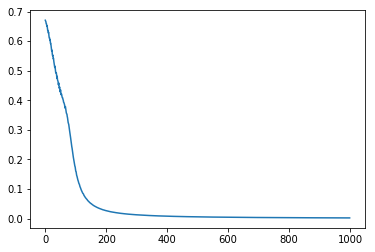

In [28]:
np.random.seed(1007) # set random seed
EPOCH = 1000 # set training epochs
N = X.shape[0] # get number of training data

# craete a MLP with layer size [2,4,2] and learning_rate 0.1
mlp = MLP([2, 4, 2], learning_rate=.1, activation="relu")

loss = np.zeros(EPOCH) # store losses
for epoch in range(EPOCH):
    # train on each training data
    for i in range(N):
        mlp.train(X[i], Y[i])
        
    # compute loss
    for i in range(N):
        loss[epoch] += mlp.loss(X[i], Y[i])
        
    loss[epoch] /= N
    
# plot loss curve
plt.figure()
ix = np.arange(EPOCH)
plt.plot(ix, loss)